# Installing missing packages

In [1]:
!pip install pydub
!pip install nlpaug
!pip install glob2

^C


# Loading Packages

In [1]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import glob
from tqdm import tqdm
from IPython.display import Audio
import numpy as np
#import tensorflow as tf
import soundfile
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
from pydub import AudioSegment
import math as mt
import librosa.display
from sklearn.preprocessing import minmax_scale
 
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score
import nlpaug.augmenter.audio as naa

C:\Users\Dragox.RS\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Data/Signal Visualization

#### Now Let's visualize some Audio analysis 

In [ ]:
file = 'C:\\Users\\Dragox.RS\\Documents\\GitHub\\Speech-Emotion-Recognition\Data\\Actor_03\\03-01-01-01-02-02-03.wav'
signal , sr = librosa.load(file , sr = 22050)

##### Let’s use a wave plot to visualize the audio file or signal.

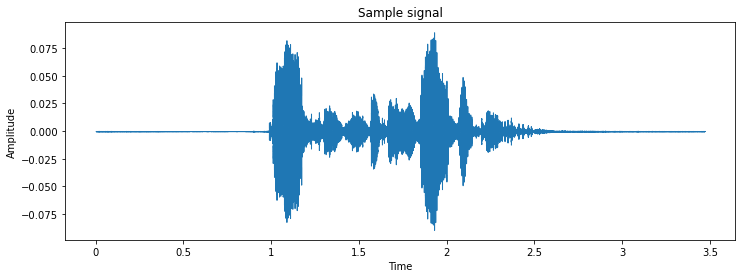

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Sample signal")
plt.show()

In [ ]:
# Play the audio
ipd.Audio(signal, rate=sr)

#### Fourier Transform

###### Fourier Transform is a function that takes a signal in the time domain as input and outputs its decomposition into frequencies. Let’s plot a graph using it to see the distribution of frequencies.

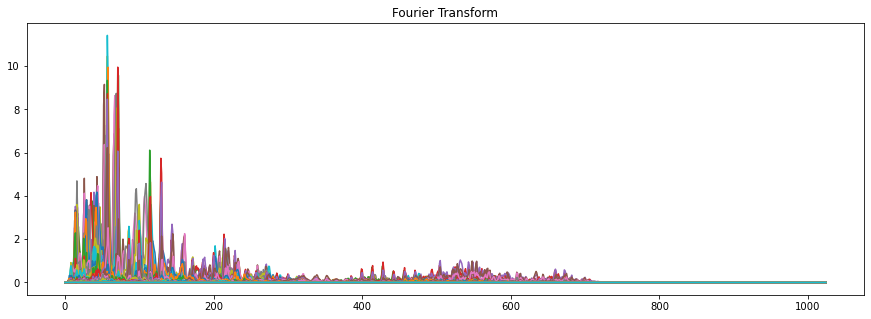

In [ ]:
n_fft = 2048
hop_length = 512
D = np.abs(librosa.stft(signal, n_fft = n_fft, hop_length = hop_length))
plt.figure(figsize = (15, 5))
plt.plot(D)
plt.title('Fourier Transform')
plt.show()

### Spectrogram

###### A spectrogram is a representation of the loudness of a signal over time at various frequencies present in a particular waveform. Let’s plot a spectrogram for our audio file.

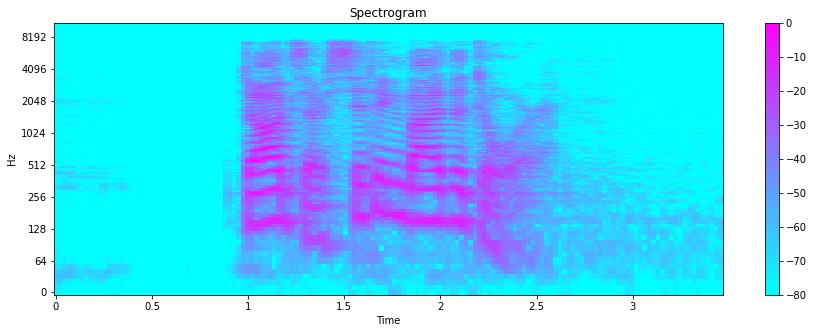

In [ ]:
DB = librosa.amplitude_to_db(D, ref = np.max)
plt.figure(figsize = (15, 5))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log', cmap = 'cool')
plt.colorbar()
plt.title('Spectrogram')
plt.show()

#### Harmonics & Perceptual

###### Harmonics are unwanted higher frequencies superimposed on the fundamental waveform creating a distorted wave pattern. Perceptual represents the sound rhythm and emotion. Let’s plot both of them on a graph.

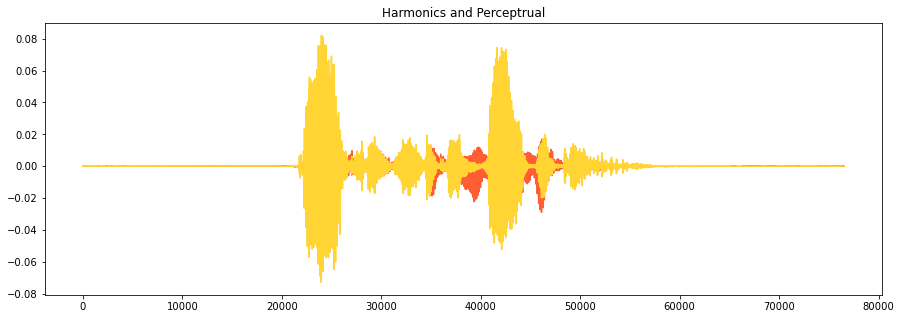

In [ ]:
a,b = librosa.effects.hpss(signal)
plt.figure(figsize = (15, 5))
plt.plot(a, color = '#FF5E33');
plt.plot(b, color = '#FFD433');
plt.title('Harmonics and Perceptrual')
plt.show()

#### Spectral Centroid

###### The spectral centroid indicates where the center of mass of the spectrum is located.

<ipython-input-222-325f738080ed>:2: FutureWarning: Pass y=[ 5.8688427e-05  4.3535452e-05  1.7945735e-05 ... -3.6948120e-07
 -2.9427385e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(signal, sr=sr)[0]


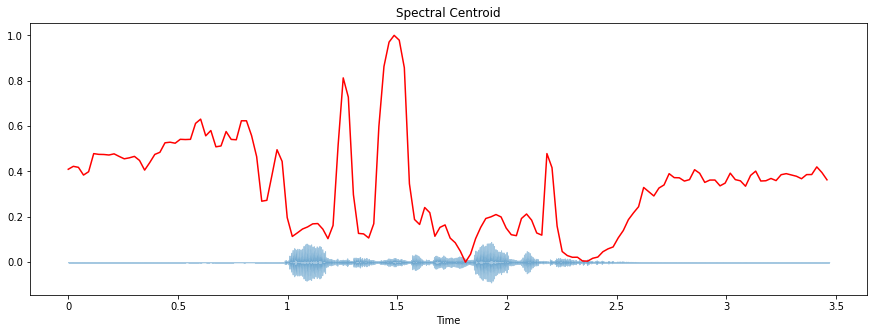

In [ ]:

spectral_centroids = librosa.feature.spectral_centroid(signal, sr=sr)[0]
plt.figure(figsize=(15, 5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
librosa.display.waveshow(signal, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_centroids,axis=0), color='r')
plt.title('Spectral Centroid')
plt.show()

#### Chromogram

##### We will create a chromogram in which the entire spectrum will be projected onto 12 bins representing the 12 distinct semitones of the musical octave.

<ipython-input-229-6ecf78577d5a>:2: FutureWarning: Pass y=[ 5.8688427e-05  4.3535452e-05  1.7945735e-05 ... -3.6948120e-07
 -2.9427385e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chromagram = librosa.feature.chroma_stft(signal, sr=sr, hop_length=hop_length)


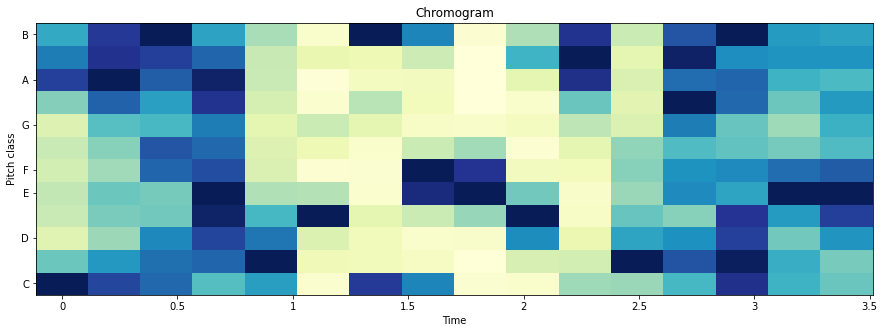

In [ ]:
hop_length = 5000
chromagram = librosa.feature.chroma_stft(signal, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='YlGnBu')
plt.title('Chromogram')
plt.show()

#### Zero Crossing Rate

###### The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

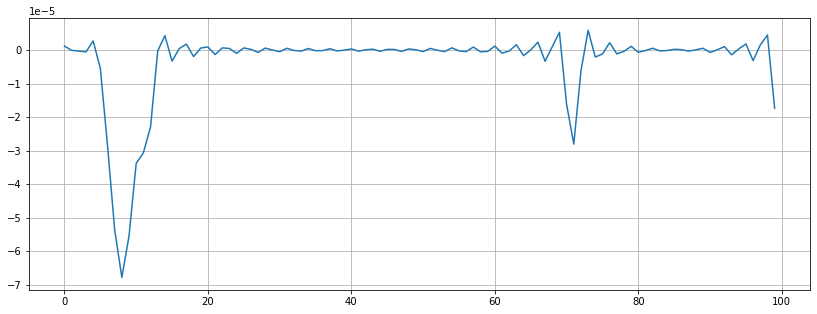

In [ ]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(signal[n0:n1])
plt.grid()


# Data Pre-processing

In [2]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [3]:
# Extracting features from Audio Samples
def extract_feature(y_data,sr, mfcc, chroma, mel,crossing_0):
    if chroma:
        stft=np.abs(librosa.stft(y_data))
        result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=y_data, sr=sr, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(y_data, sr=sr).T,axis=0)
        result=np.hstack((result, mel))
    if crossing_0:
        crossing_0= np.mean(librosa.feature.zero_crossing_rate(y_data))
        result=np.hstack((result, crossing_0))
    return result

In [4]:
#Augumenting Data with nlpaug
def augumente_data(file_path):
    data, sr = librosa.load(file_path)
    
    data_L=[]
    data_L.append(data)
    #Crop Augmenter
    aug = naa.CropAug(sampling_rate=sr)
    data_L.append(aug.augment(data))
    
    #Loudness Augmenter
    aug = naa.LoudnessAug()
    data_L.append(aug.augment(data))
    
    
    #Mask Augmenter
    aug = naa.MaskAug(sampling_rate=sr, mask_with_noise=False)
    data_L.append(aug.augment(data))
    
    #Noise
    aug = naa.NoiseAug()
    data_L.append(aug.augment(data))
    
    #Pitch_aug
    aug = naa.PitchAug(sampling_rate=sr, factor=(2,3))
    data_L.append(aug.augment(data))
    
    #Speed_Aug
    aug = naa.SpeedAug()
    data_L.append(aug.augment(data))
    
    return data_L

In [ ]:
#Load the data and extract features for each sound file
#"C:\\Users\\Dragox.RS\\Documents\\GitHub\\Speech-Emotion-Recognition\\Data\Actor_*\\*.wav"
def load_data():
    x,y=[],[]
    for file in tqdm(glob.glob("/content/files/Actor_*//*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
 
        _ , sr = librosa.load(file)
        for y_data in augumente_data(file):
            feature=extract_feature(y_data, sr, mfcc=True, chroma=True, mel=True,crossing_0=True)
            x.append(feature)
            y.append(emotion)
    return np.array(x),y

In [ ]:
X,y=load_data()

In [ ]:
df_x = pd.DataFrame(X)
df_y = pd.DataFrame(y)
df = pd.concat([df_x,df_y],axis=1)

In [ ]:
#To encode the labels
#df["0.1"].replace(emotions,inplace=True)

In [ ]:
X=df.drop(["Unnamed: 0","0.1"],axis=1)
y=df["0.1"]

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

#### Normalizing the inputs

In [ ]:

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std



#### Exporting Data due it takes too much to load

In [ ]:
df.to_csv("Data_Augumented.csv")

#### Loading the Data 

In [ ]:
df = pd.read_csv("Data_Augumented.csv")

# Moutning & Unzip Data from GDrive

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/speech-emotion-recognition-ravdess-data.zip", 'r')
zip_ref.extractall("/content/files")
zip_ref.close()

In [ ]:
#Load the data and extract features for each sound file

def load_data():
    x,y=[],[]
    for file in tqdm(glob.glob("/content/files/Actor_*//*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
 
        _ , sr = librosa.load(file)
        for y_data in augumente_data(file):
            feature=extract_feature(y_data, sr, mfcc=True, chroma=True, mel=True,crossing_0=True)
            x.append(feature)
            y.append(emotion)
    return np.array(x),y

In [ ]:
X,y=load_data()

100%|██████████| 1440/1440 [17:31<00:00,  1.37it/s]


# Creating a Model

## MLP Classifier

In [ ]:
model_mlp=MLPClassifier(activation="relu", alpha= 0.0001, batch_size="auto", epsilon=1e-08, hidden_layer_sizes=(500, 400, 300, 200, 100), learning_rate_init= 0.0001,learning_rate='adaptive', max_iter=600)

model_mlp.fit(x_train,y_train)

MLPClassifier(hidden_layer_sizes=(500, 400, 300, 200, 100),
              learning_rate='adaptive', learning_rate_init=0.0001,
              max_iter=600)

In [ ]:
# Predict for the test set
y_pred=model_mlp.predict(x_test)
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 67.36%


In [ ]:
#GRID = [
#    {
#     'solver': ['adam'],
#     'learning_rate_init': [0.0001],
#     'max_iter': [300],
#     'hidden_layer_sizes': [(500, 400, 300, 200, 100), (400, 400, 400, 400, 400), (300, 300, 300, 300, 300), (200, 200, 200, 200, 200)],
#     'activation': ['logistic', 'tanh', 'relu'],
#     'alpha': [0.0001, 0.001, 0.005],
#     'early_stopping': [True, False]
#     }
#]
#
GRID = [
    {
     'solver': ['adam'],
     'learning_rate_init': [0.0001],
     'max_iter': [300],
     'hidden_layer_sizes': [(500, 400, 300, 200, 100)],
     'activation': ['logistic','relu'],
     'alpha': [0.0001, 0.001],
     }
]


In [ ]:
model=MLPClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=GRID,
                            n_jobs=-1, cv=2, refit=True, verbose=2, 
                            return_train_score=False)

grid_search.fit(x_train, y_train)
prediction = grid_search.predict(x_test)

print(grid_search.best_params_)
print('Score of best mlp_classifier :\t{}'.format(grid_search.score(x_test, y_test)))
print(classification_report(y_test, prediction))

<IPython.core.display.Javascript object>

Fitting 2 folds for each of 4 candidates, totalling 8 fits
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (500, 400, 300, 200, 100), 'learning_rate_init': 0.0001, 'max_iter': 300, 'solver': 'adam'}
Score of best rf_classifier :	0.7872023809523809


NameError: name 'prediction_rf' is not defined

In [ ]:
print('Score of best mlp_classifier :\t{}'.format(grid_search.score(x_test, y_test)))
print(classification_report(y_test, prediction))

Score of best rf_classifier :	0.7872023809523809
              precision    recall  f1-score   support

       angry       0.82      0.82      0.82       251
        calm       0.76      0.86      0.81       282
     disgust       0.82      0.80      0.81       290
     fearful       0.82      0.79      0.81       282
       happy       0.77      0.77      0.77       278
     neutral       0.72      0.66      0.69       131
         sad       0.76      0.76      0.76       249
   surprised       0.80      0.78      0.79       253

    accuracy                           0.79      2016
   macro avg       0.78      0.78      0.78      2016
weighted avg       0.79      0.79      0.79      2016



In [ ]:
import pickle
# now you can save it to a file
with open('MLP_base_C.pkl', 'wb') as f:
    pickle.dump(model_mlp, f)

# and later you can load it
#with open('filename.pkl', 'rb') as f:
#    clf = pickle.load(f)

## KNeighborsClassifier - (KNN)

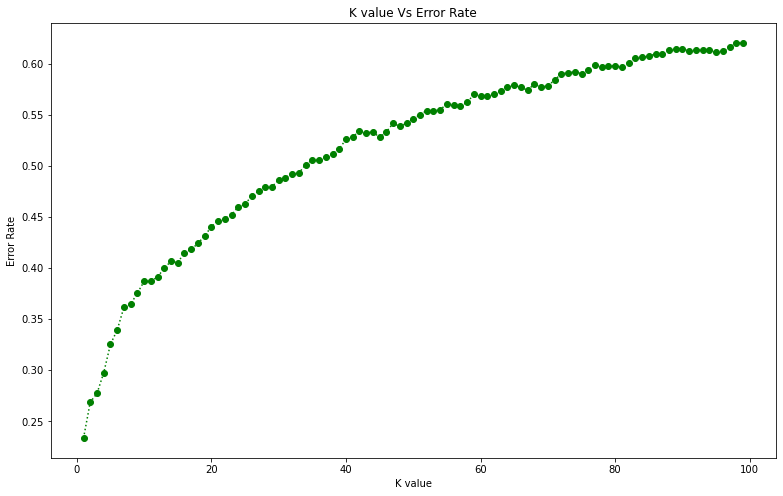

In [ ]:
error_rate=[]
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(13,8))
plt.plot(range(1,100), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
plt.xlabel('K value')
plt.ylabel('Error Rate')
plt.title('K value Vs Error Rate')
plt.show() 

In [ ]:
knn_model = KNeighborsClassifier()

knn_pipe = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', KNeighborsClassifier()) 
    ])

knn_param = {
        'knn__n_neighbors': [1,3], # usually odd numbers
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute'],
        'knn__leaf_size':np.arange(10,31,10).tolist(),
        'knn__p':[1,2]
    }

grid_knn = GridSearchCV(knn_pipe, 
                    param_grid = knn_param, 
                    n_jobs = -1, 
                    cv = 5,
                    refit = "accuracy_score",
                    verbose=2)

grid_knn.fit(x_train, y_train)

prediction_knn = grid_knn.predict(x_test)

print(grid_knn.best_params_)
print('Score of best knn_regressor :\t{}'.format(grid_knn.score(x_test, y_test)))

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}
Score of best knn_regressor :	0.7738095238095238


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1,p= 1, weights='uniform',algorithm='auto',leaf_size=15).fit(x_train,y_train)
pred = model.predict(x_test)
print(classification_report(y_test,pred))
print('Score of KNN :\t{}'.format(model.score(x_test, y_test)))

              precision    recall  f1-score   support

       angry       0.79      0.79      0.79       280
        calm       0.77      0.81      0.79       263
     disgust       0.77      0.75      0.76       264
     fearful       0.82      0.82      0.82       250
       happy       0.82      0.73      0.77       294
     neutral       0.61      0.80      0.69       124
         sad       0.77      0.70      0.73       263
   surprised       0.77      0.82      0.80       278

    accuracy                           0.77      2016
   macro avg       0.77      0.78      0.77      2016
weighted avg       0.78      0.77      0.77      2016

Score of KNN :	0.7738095238095238


## XGB Classifier

In [ ]:
%time
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score


# create XGBoost instance with default hyper-parameters
xgb_estimator = xgb.XGBClassifier(objective='multi:softmax')


# fit the model
xgb_estimator.fit(x_train, y_train)

# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, xgb_estimator.predict(x_test))*100))

Wall time: 0 ns


C:\Users\Dragox.RS\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on test data: 75.2%


## AdaBoostClassifier

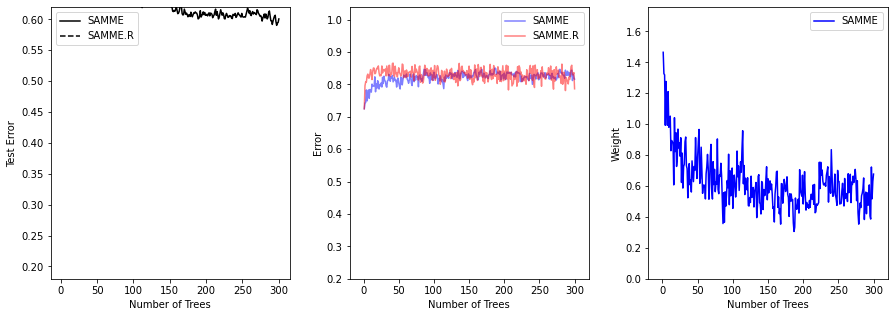

In [ ]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1.5,
    algorithm="SAMME",
)

bdt_real.fit(x_train, y_train)
bdt_discrete.fit(x_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
    bdt_real.staged_predict(x_test), bdt_discrete.staged_predict(x_test)
):
    real_test_errors.append(1.0 - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(1.0 - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1), discrete_test_errors, c="black", label="SAMME")
plt.plot(
    range(1, n_trees_real + 1),
    real_test_errors,
    c="black",
    linestyle="dashed",
    label="SAMME.R",
)
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel("Test Error")
plt.xlabel("Number of Trees")

plt.subplot(132)
plt.plot(
    range(1, n_trees_discrete + 1),
    discrete_estimator_errors,
    "b",
    label="SAMME",
    alpha=0.5,
)
plt.plot(
    range(1, n_trees_real + 1), real_estimator_errors, "r", label="SAMME.R", alpha=0.5
)
plt.legend()
plt.ylabel("Error")
plt.xlabel("Number of Trees")
plt.ylim((0.2, max(real_estimator_errors.max(), discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights, "b", label="SAMME")
plt.legend()
plt.ylabel("Weight")
plt.xlabel("Number of Trees")
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

# Test of a new input - Happy Testing!

In [ ]:
# and later you can load it
with open('MLP_base_C.pkl', 'rb') as f:
    model = pickle.load(f)

<IPython.core.display.Javascript object>

#### Spliting the audio input to 3s segment for a better result

In [ ]:
file_name='C:\\Users\\Dragox.RS\\Downloads\\Music\\243642__xtrgamr__sing-along-large-crowd-big-party.wav' #Enter your file path instead
duration = round(librosa.get_duration(filename=file_name))
for i in range(1,duration+1,3):
    t1 = i*3000+20
    t2 = (i+1)* 3000
    newAudio = AudioSegment.from_wav(file_name)
    newAudio = newAudio[t1:t2+10]
    audio_name = "Test_Sample_" + str(i)
    newAudio.export(f'Test Samples/{audio_name}.wav', format="wav")

In [ ]:


import IPython.display as ipd
ipd.Audio(file_name) # load a local WAV file



#### Predicting each of the segments samples

In [ ]:
Pred_L=[]
try:
    for i in range(1,duration,3):
        file_name = f"Test Samples/Test_Sample_{i}.wav"
        y_data, sr = librosa.load(file_name)
        Vector_new_input=[]
        feature=extract_feature(y_data, sr, mfcc=True, chroma=True, mel=True,crossing_0=True)
        Vector_new_input.append(feature)
        Pred_L.append(model.predict(Vector_new_input))
except Exception:
    pass

<ipython-input-4-408f46c46031>:12: FutureWarning: Pass y=[ 1.1042384e-01  1.8233442e-01  2.1041566e-01 ... -8.2798515e-08
  5.7858053e-08 -3.8406988e-08] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(y_data, sr=sr).T,axis=0)


In [ ]:
def to_List(L):
    N=np.zeros_like(L)
    N=N.flatten()
    for i in range(0,len(L)):
        N[i]=L[i][0]
    return N

In [ ]:
Pred_L=to_List(Pred_L)

In [ ]:
def mostFrequent(arr, n):
 
    # Insert all elements in Hash.
    Hash = dict()
    for i in range(n):
        if arr[i] in Hash.keys():
            Hash[arr[i]] += 1
        else:
            Hash[arr[i]] = 1
 
    # find the max frequency
    max_count = 0
    res = -1
    for i in Hash:
        if (max_count < Hash[i]):
            res = i
            max_count = Hash[i]
         
    return res

### Final Result

In [ ]:
print(mostFrequent(Pred_L, len(Pred_L)))

sad


### Bi-Directional LSTM MODEL

In [14]:
from tensorflow.python.keras.layers import LSTM
from attention import Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

## Getting Data Ready

In [ ]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = np.abs((xx - h) // 2)
    aa =np.abs(xx - a - h)

    b = np.abs((yy - w) // 2)
    bb = np.abs(yy - b - w)

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [ ]:
hop_length = 512 #the default spacing between frames
n_fft = 255 #number of samples 


In [ ]:
#Augumenting Data with nlpaug
def augumente_data(file_path):
    data, sr = librosa.load(file_path)
    
    data_L=[]
    data_L.append(data)
    #Crop Augmenter
   # aug = naa.CropAug(sampling_rate=sr)
   # data_L.append(aug.augment(data))
   # 
   # #Loudness Augmenter
   # aug = naa.LoudnessAug()
   # data_L.append(aug.augment(data))
   # 
   # 
   # #Mask Augmenter
   # aug = naa.MaskAug(sampling_rate=sr, mask_with_noise=False)
   # data_L.append(aug.augment(data))
   # 
   # #Noise
   # aug = naa.NoiseAug()
   # data_L.append(aug.augment(data))
   # 
   # #Pitch_aug
   # aug = naa.PitchAug(sampling_rate=sr, factor=(2,3))
   # data_L.append(aug.augment(data))
   # 
   # #Speed_Aug
   # aug = naa.SpeedAug()
   # data_L.append(aug.augment(data))
    
    return data_L

In [ ]:
#Emotions in the RAVDESS dataset
emotions={
  'neutral':0,
  'calm':1,
  'happy':2,
  'sad':3,
  'angry':4,
  'fearful':5,
  'disgust':6,
  'surprised':7
}

In [4]:
# Preprocessing parameters
sr = 44100 # Sampling rate
duration = 5
hop_length = 347 # to make time steps 128
fmin = 20
fmax = sr // 2
n_mels = 128
n_fft = n_mels * 20
samples = sr * duration

def read_audio(path):
    '''
    Reads in the audio file and returns
    an array that we can turn into a melspectogram
    '''
    y, _ = librosa.core.load(path, sr=44100)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    if len(y) > samples: # long enough
        y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(audio):
    '''
    Convert to melspectrogram after audio is read in
    '''
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=sr,
                                                 n_mels=n_mels,
                                                 hop_length=hop_length,
                                                 n_fft=n_fft,
                                                 fmin=fmin,
                                                 fmax=fmax)
    return librosa.power_to_db(spectrogram).astype(np.float32)

def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    mels = audio_to_melspectrogram(read_audio(path))
    return mels

def convert_wav_to_image(path):
    X = []
    x = read_as_melspectrogram(path)
    X.append(x.transpose())
    return X

def normalize(img):
    '''
    Normalizes an array 
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

def normalize_dataset(X):
    '''
    Normalizes list of arrays
    (subtract mean and divide by standard deviation)
    '''
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset

# Preprocess dataset and create validation sets
#X = np.array(convert_wav_to_image(df, [train_curated_path]))
#X = normalize_dataset(X)
#Y = df[label_columns].values
#x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=seed)



In [4]:
#Load the data and extract features for each sound file

def load_data():
    x,y=[],[]
    for file in tqdm(glob.glob("C:\\Users\\Dragox.RS\\Documents\\GitHub\\Speech-Emotion-Recognition\\Data\Actor_*\\*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]

        feature=convert_wav_to_image(file)

        x.append(feature)
        y.append(emotion)
    return x,y

In [5]:
X,y = load_data()

  0%|                                                                                         | 0/1440 [00:00<?, ?it/s]<ipython-input-3-872072417cac>:32: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio,
 78%|█████████████████████████████████████████████████████████████▏                | 1129/1440 [07:42<02:11,  2.37it/s]<ipython-input-3-872072417cac>:32: FutureWarning: Pass y=[0.00011281 0.00012632 0.00014263 ... 0.0019827  0.00202025 0.00208541] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio,
100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [09:51<00:00,  2.43it/s]


In [7]:
X=np.asarray(X)
X = normalize_dataset(X)

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [8]:
x_train=np.asarray(x_train)
x_val=np.asarray(x_val)
y_train=np.asarray(y_train)
y_val=np.asarray(y_val)


In [9]:
x_train=x_train.reshape(1152,636,128)
x_val=x_val.reshape(288,636,128)

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(y_train)
Y_val = label_encoder.fit_transform(y_val)


In [11]:
Y_train =np.eye(8)[Y_train]
Y_val =np.eye(8)[Y_val]

In [11]:
#from tensorflow.keras.utils import to_categorical
#Y_train = to_categorical(Y_train, 8)
#Y_val = to_categorical(Y_val, 8)
#

In [12]:
np.save('X_data.npy', X)    # .npy extension is added if not given
#d = np.load('test3.npy')
#a == d

In [5]:
   # .npy extension is added if not given
X = np.load('X_data.npy')
#a == d

In [13]:
np.save('y_data.npy', y)

In [6]:
y=np.load('y_data.npy')

In [29]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [18]:
tf.config.run_functions_eagerly(True)

<IPython.core.display.Javascript object>

### Bi-LSTM w/o Attention

In [ ]:


# Neural network model
input_shape = (636,128)
optimizer = Adam(0.005, beta_1=0.1, beta_2=0.001, amsgrad=True)
n_classes = 8

model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape))
model.add(Attention(636))
model.add(Dropout(0.2))
model.add(Dense(400))
model.add(Flatten())
model.add(Dropout(0.2)) 
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])



In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=2, patience=3)
# Set callback functions to early stop training and save the best model so far
checkpoint = [ModelCheckpoint(filepath='models.hdf5')]

# Train model
hist = model.fit(x_train,
          Y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_val, Y_val),
          callbacks = [es,checkpoint])



C:\Users\Dragox.RS\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
36/36 [==============================] - 697s 19s/step - loss: 504.9854 - acc: 0.1710 - val_loss: 52.1023 - val_acc: 0.2500
Epoch 2/10
36/36 [==============================] - 691s 19s/step - loss: 32.4296 - acc: 0.3160 - val_loss: 17.9825 - val_acc: 0.3333
Epoch 3/10
36/36 [==============================] - 676s 19s/step - loss: 11.1175 - acc: 0.4740 - val_loss: 9.3829 - val_acc: 0.3507
Epoch 4/10
36/36 [==============================] - 659s 18s/step - loss: 5.9546 - acc: 0.5538 - val_loss: 9.4437 - val_acc: 0.4097
Epoch 5/10
36/36 [==============================] - 824s 23s/step - loss: 2.9388 - acc: 0.6970 - val_loss: 7.3664 - val_acc: 0.3889
Epoch 6/10
36/36 [==============================] - 1008s 28s/step - loss: 1.3435 - acc: 0.7786 - val_loss: 5.6213 - val_acc: 0.5000
Epoch 7/10
36/36 [==============================] - 1548s 44s/step - loss: 0.7958 - acc: 0.8464 - val_loss: 5.1475 - val_acc: 0.4861
Epoch 8/10
36/36 [==============================] - 1021s 29s/step -

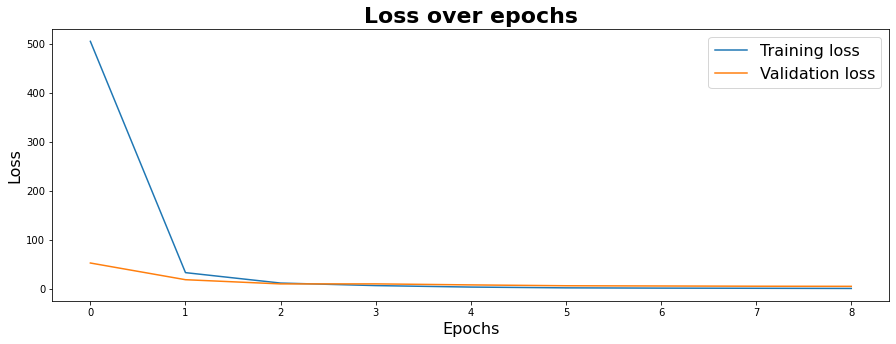

In [20]:
# Visualize loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']
stopped_epoch = es.stopped_epoch
epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()

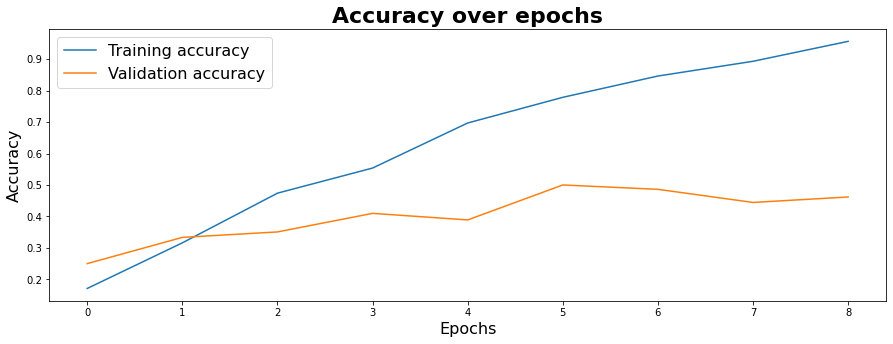

In [21]:
# Visualize Accuracy
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=2, patience=3)
# Set callback functions to early stop training and save the best model so far
checkpoint = [ModelCheckpoint(filepath='models_w_Attention.hdf5')]

# Train model
hist = model.fit(x_train,
          Y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_val, Y_val),
          callbacks = [es,checkpoint])



Epoch 1/10
36/36 [==============================] - 633s 17s/step - loss: 5.4892 - acc: 0.1502 - val_loss: 1.9849 - val_acc: 0.2222
Epoch 2/10
36/36 [==============================] - 909s 25s/step - loss: 1.9652 - acc: 0.2413 - val_loss: 1.8366 - val_acc: 0.3160
Epoch 3/10
36/36 [==============================] - 670s 19s/step - loss: 1.8724 - acc: 0.2995 - val_loss: 1.6578 - val_acc: 0.3681
Epoch 4/10
36/36 [==============================] - 604s 17s/step - loss: 1.7797 - acc: 0.3351 - val_loss: 1.6691 - val_acc: 0.4306
Epoch 5/10
36/36 [==============================] - 667s 19s/step - loss: 1.6856 - acc: 0.3620 - val_loss: 1.6697 - val_acc: 0.3924
Epoch 6/10
36/36 [==============================] - 607s 17s/step - loss: 1.6613 - acc: 0.3759 - val_loss: 1.5018 - val_acc: 0.4132
Epoch 7/10
36/36 [==============================] - 647s 18s/step - loss: 1.5471 - acc: 0.4418 - val_loss: 1.4409 - val_acc: 0.4410
Epoch 8/10
36/36 [==============================] - 654s 18s/step - loss: 1.

In [34]:


score = model.evaluate(x_val, Y_val, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))



val_loss = 1.444 and val_acc = 0.469


In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=2, patience=7)
# Set callback functions to early stop training and save the best model so far
checkpoint = [ModelCheckpoint(filepath='models_w_Attention.hdf5')]

# Train model
histo = model.fit(x_train,
          Y_train,
          batch_size=48,
          epochs=30,
          validation_data=(x_val, Y_val),
          callbacks = [es,checkpoint])



Epoch 1/30
24/24 [==============================] - 467s 20s/step - loss: 1.2332 - acc: 0.5443 - val_loss: 1.2836 - val_acc: 0.5556
Epoch 2/30
24/24 [==============================] - 444s 19s/step - loss: 1.2261 - acc: 0.5590 - val_loss: 1.4152 - val_acc: 0.4653
Epoch 3/30
24/24 [==============================] - 444s 19s/step - loss: 1.1841 - acc: 0.5686 - val_loss: 1.3184 - val_acc: 0.5104
Epoch 4/30
24/24 [==============================] - 447s 19s/step - loss: 1.1443 - acc: 0.5833 - val_loss: 1.2686 - val_acc: 0.5000
Epoch 5/30
24/24 [==============================] - 612s 26s/step - loss: 1.0858 - acc: 0.6033 - val_loss: 1.1921 - val_acc: 0.5660
Epoch 6/30
24/24 [==============================] - 756s 32s/step - loss: 1.0756 - acc: 0.6181 - val_loss: 1.2083 - val_acc: 0.5556
Epoch 7/30
24/24 [==============================] - 750s 32s/step - loss: 1.0049 - acc: 0.6380 - val_loss: 1.3018 - val_acc: 0.5451
Epoch 8/30
24/24 [==============================] - 687s 29s/step - loss: 1.

KeyboardInterrupt: 

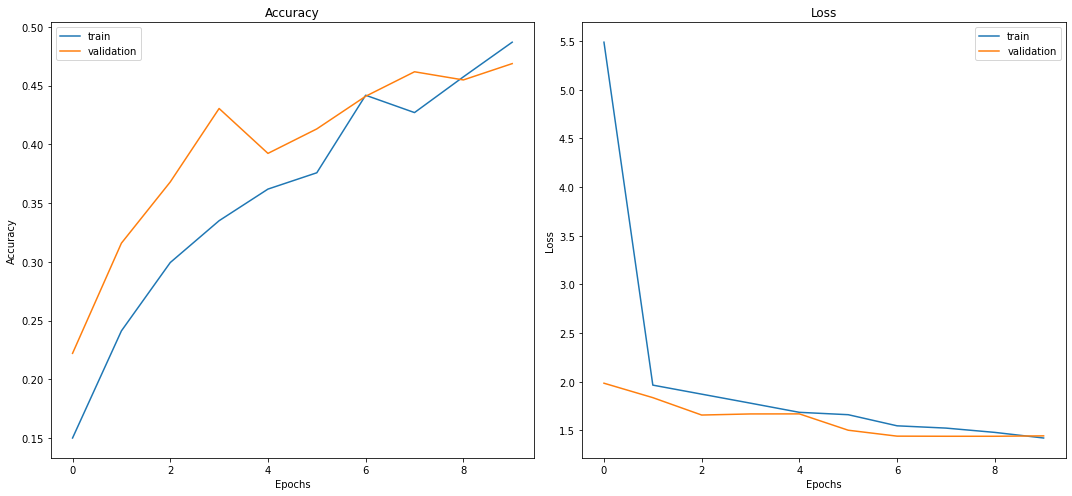

In [44]:


plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



##### Horay!! we got 95% on model accuracy and 62% on val set, maybe if we applied one the Data augumentation function would add the accuracy of the val set 